In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
import pickle

SEED = 42
np.random.seed(SEED)

from sklearn.manifold import TSNE
from sklearn.model_selection import GroupShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, accuracy_score, recall_score, roc_auc_score

import seaborn as sns
sns.set_style("white")
sns.set(font_scale = 1.4)
sns.set_style("ticks")
pd.set_option("display.max_colwidth", False)
pd.set_option('display.expand_frame_repr', False)

from Bio.SeqUtils.ProtParam import ProteinAnalysis
from Bio.SeqUtils.IsoelectricPoint import IsoelectricPoint as IP
import math
import tempfile
import subprocess


AA_array = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
       'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

kd = {"A": 1.8, "R": -4.5, "N": -3.5, "D": -3.5,
      "C": 2.5,  "Q": -3.5, "E": -3.5, "G": -0.4, "H": -3.2,
      "I": 4.5,
      "L": 3.8, "K": -3.9,
      "M": 1.9,
      "F": 2.8, "P": -1.6, "S": -0.8, "T": -0.7, "W": -0.9, "Y": -1.3,
      "V": 4.2} 


def hydrophobicity(seq):
    sequence = ProteinAnalysis(seq)
    HB = 0
    for k in range(0, len(AA_array)):
        HB = HB + sequence.count_amino_acids()[AA_array[k]] * kd[AA_array[k]]        
    
    return HB


def Shannon_entropy(seq):
    sequence =  ProteinAnalysis(seq)
    entropy = 0
    for k in range(0, len(AA_array)):
        if sequence.get_amino_acids_percent()[AA_array[k]] == 0:
            entropy = entropy + 0
        else:
            entropy = entropy - math.log2(sequence.get_amino_acids_percent()[AA_array[k]]) * sequence.get_amino_acids_percent()[AA_array[k]]        
    return entropy


def extract_LCR(seq):
    tmp_LCR = tempfile.NamedTemporaryFile()  
    with open(tmp_LCR.name, 'w') as f_LCR:
         f_LCR.write('>1\n' + str(seq))
    tmp_LCR.seek(0)
    
    out = subprocess.Popen(['segmasker', '-in', str(tmp_LCR.name)], 
           stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
    stdout_LCR, stderr_LCR = out.communicate() 
    stdout_LCR = stdout_LCR.split()[1:]
    
    LCR_start_values = []; LCR_end_values = []    
    for i in range(0, int(len(stdout_LCR)/3)):
        LCR_start_values.append(int(str(stdout_LCR[3*i],'utf-8')))
        LCR_end_values.append(int(str(stdout_LCR[3*i + 2],'utf-8')))
    LCR_residues = []
    for i in range(0, len(LCR_start_values)):
        LCR_residues.extend(list(np.linspace(LCR_start_values[i], LCR_end_values[i], (LCR_end_values[i] - LCR_start_values[i] + 1) )))
    LCR_residues = sorted(list(set(LCR_residues)))
    LCR_sequence = ''
    for i in range(0, len(LCR_residues)):
        LCR_sequence = LCR_sequence + seq[int(LCR_residues[i]-1)]
        
    return len(LCR_residues), LCR_sequence


def extract_IDR(seq):
    tmp_IDR = tempfile.NamedTemporaryFile()  
    with open(tmp_IDR.name, 'w') as f_IDR:
         f_IDR.write('>1\n' + str(seq))
    tmp_IDR.seek(0)
    
    out = subprocess.Popen(['python', 'tools/iupred2a.py', str(tmp_IDR.name), 'long'], 
           stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
    stdout_IDR, stderr_IDR = out.communicate()
    stdout_IDR = stdout_IDR.split()[40:]
    
    IDR_prob = []
    for i in range(0, int(len(stdout_IDR)/3)):
        IDR_prob.append(float(str(stdout_IDR[3*i + 2], 'utf-8')))
       
    TH1 = 0.5
    TH2 = 20
    AAs   = pd.Series(list(map(lambda i:i, seq)))    
    IDR_residues = []
    current = 0
    for t in range(0, len(IDR_prob)):
        if IDR_prob[t] > TH1:
            current = current + 1
            if t == len(IDR_prob) - 1:
                if current > TH2:
                    IDR_residues.extend(range(t - current , t + 1))
        else:
            if current > TH2:
                IDR_residues.extend(range(t - current , t + 1))
                current = 0
            else:
                current = 0
    
    return len(IDR_residues)


def get_AA_count(seq, AA):
    if type(seq) == float:
        count = 0
    else:
        sequence = ProteinAnalysis(seq)
        count = sequence.count_amino_acids()[str(AA)]
    return count

#Types of amino acids
Hydrophobic_AAs = ['A', 'I', 'L', 'M', 'F', 'V']
Polar_AAs = ['S', 'Q', 'N', 'G', 'C', 'T', 'P']
Cation_AAs = ['K', 'R', 'H']
Anion_AAs = ['D', 'E']
Arom_AAs = ['W', 'Y', 'F']


def sigma(seq):
    A = seq.count('0') / len(seq)
    B = seq.count('1') / len(seq)
    sigma =   (A-B)**2 / (A+B) 
    return sigma


def delta(seq, window, AA_type1, AA_type2):
    for character in AA_type1:
        seq = seq.replace(character, "0")
    for character in AA_type2:
        seq = seq.replace(character, "1")        
    sigmas = []
    for i in range(0, len(seq) - window):
        seq_s = seq[i : i+window]
        sigmas.append(sigma(seq_s) - sigma(seq)**2)
    omega = np.sum(sigmas) / len(sigmas)
            
    return omega
	 
	 

from gensim.models import word2vec

def split_ngrams(seq, n):
    """
    'AGAMQSASM' => [['AGA', 'MQS', 'ASM'], ['GAM','QSA'], ['AMQ', 'SAS']]
    """
    a, b, c = zip(*[iter(seq)]*n), zip(*[iter(seq[1:])]*n), zip(*[iter(seq[2:])]*n)
    str_ngrams = []
    for ngrams in [a,b,c]:
        x = []
        for ngram in ngrams:
            x.append("".join(ngram))
        str_ngrams.append(x)
    return str_ngrams

def generate_corpusfile(fasta_fname, n, corpus_fname):
    '''
    Args:
        fasta_fname: corpus file name
        n: the number of chunks to split. In other words, "n" for "n-gram"
        corpus_fname: corpus_fnameput corpus file path
    Description:
        Protvec uses word2vec inside, and it requires to load corpus file
        to generate corpus.
    '''
    f = open(corpus_fname, "w")
    fasta = Fasta(fasta_fname)
    for record_id in tqdm(fasta.keys(), desc='corpus generation progress'):
        r = fasta[record_id]
        seq = str(r)
        ngram_patterns = split_ngrams(seq, n)
        for ngram_pattern in ngram_patterns:
            f.write(" ".join(ngram_pattern) + "\n")
    f.close()
    
'''
Binary representation of amino acid residue and amino acid sequence
e.g.
    'A' => [0, 0, 0, 0, 0]
    'AGGP' => [[0, 0, 0, 0, 0], [0, 1, 1, 0, 1], [0, 1, 1, 0, 1], [0, 1, 1, 1, 1]]
'''

AMINO_ACID_BINARY_TABLE = {
    'A': [0, 0, 0, 0, 0],
    'C': [0, 0, 0, 0, 1],
    'D': [0, 0, 0, 1, 0],
    'E': [0, 0, 0, 1, 1],
    'F': [0, 0, 1, 0, 0],
    'G': [0, 0, 1, 0, 1],
    'H': [0, 0, 1, 1, 0],
    'I': [0, 0, 1, 1, 1],
    'K': [0, 1, 0, 0, 0],
    'L': [0, 1, 0, 0, 1],
    'M': [0, 1, 0, 1, 0],
    'N': [0, 1, 0, 1, 1],
    'P': [0, 1, 1, 0, 0],
    'Q': [0, 1, 1, 0, 1],
    'R': [0, 1, 1, 1, 1],
    'S': [1, 0, 0, 0, 0],
    'T': [1, 0, 0, 0, 1],
    'V': [1, 0, 0, 1, 0],
    'W': [1, 0, 0, 1, 1],
    'Y': [1, 0, 1, 0, 0]
}

def convert_amino_to_binary(amino):
    '''
    Convert amino acid to 1-dimentional 5 length binary array
    "A" => [0, 0, 0, 0, 0]
    '''
    if not AMINO_ACID_BINARY_TABLE.has_key(amino):
        return None
    return AMINO_ACID_BINARY_TABLE[amino]


def convert_amino_acid_sequence_to_vector(sequence):
    '''
    "AGGP" => [[0, 0, 0, 0, 0], [0, 1, 1, 0, 1], [0, 1, 1, 0, 1], [0, 1, 1, 1, 1]]
    '''
    binary_vector = [convert_amino_to_binary(amino) for amino in sequence]
    if None in binary_vector:
        return None
    return binary_vector

def normalize(x):
    return x / np.sqrt(np.dot(x, x))

class ProtVec(word2vec.Word2Vec):

    def __init__(self, fasta_fname=None, corpus=None, n=3, size=100, corpus_fname="corpus.txt",  sg=1, window=25, min_count=1, workers=20):
        """
        Either fname or corpus is required.
        fasta_fname: fasta file for corpus
        corpus: corpus object implemented by gensim
        n: n of n-gram
        corpus_fname: corpus file path
        min_count: least appearance count in corpus. if the n-gram appear k times which is below min_count, the model does not remember the n-gram
        """

        self.n = n
        self.size = size
        self.fasta_fname = fasta_fname

        if corpus is None and fasta_fname is None:
            raise Exception("Either fasta_fname or corpus is needed!")

        if fasta_fname is not None:
            print('Generate Corpus file from fasta file...')
            generate_corpusfile(fasta_fname, n, corpus_fname)
            corpus = word2vec.Text8Corpus(corpus_fname)

        word2vec.Word2Vec.__init__(self, corpus, size=size, sg=sg, window=window, min_count=min_count, workers=workers)

    def to_vecs(self, seq):
        """
        convert sequence to three n-length vectors
        e.g. 'AGAMQSASM' => [ array([  ... * 100 ], array([  ... * 100 ], array([  ... * 100 ] ]
        """
        ngram_patterns = split_ngrams(seq, self.n)

        protvecs = []
        for ngrams in ngram_patterns:
            ngram_vecs = []
            for ngram in ngrams:
                try:
                    ngram_vecs.append(self[ngram])
                except:
                    raise Exception("Model has never trained this n-gram: " + ngram)
            protvecs.append(sum(ngram_vecs))
        return protvecs
    
    
    def get_vector(self, seq):
        """
        sum and normalize the three n-length vectors returned by self.to_vecs
        """
        #return normalize(sum(self.to_vecs(seq)))
        return sum(self.to_vecs(seq))

    
def load_protvec(model_fname):
    return word2vec.Word2Vec.load(model_fname)

pv = load_protvec('tools/Embeddings/swissprot_size200_window25.model')



def create_features(df):
    df['Sequence_length'] = df['sequence_final'].str.len()
    df['LCR_frac'] = [extract_LCR(seq)[0] for seq in df['sequence_final']] / df['Sequence_length']
    df['LCR_sequence'] = [extract_LCR(seq)[1] for seq in df['sequence_final']]
    df['LCR_length'] = df['LCR_sequence'].str.len()
    df['Hydrophobicity'] = [hydrophobicity(seq) for seq in df['sequence_final']]
    df['Shannon_entropy'] = [Shannon_entropy(seq) for seq in df['sequence_final']]
    df['IDR_frac'] = [extract_IDR(seq) for seq in df['sequence_final']] / df['Sequence_length']
    df['pI'] = [IP(seq).pi() for seq in df['sequence_final']]
    #df['IDR_frac'] = np.where(df['Sequence_length'] < 25, 1, df['IDR_frac'])
 
    #Types of amino acids
    Hydrophobic_AAs = ['A', 'I', 'L', 'M', 'F', 'V']
    Polar_AAs = ['S', 'Q', 'N', 'G', 'C', 'T', 'P']
    Cation_AAs = ['K', 'R', 'H']
    Anion_AAs = ['D', 'E']
    Arom_AAs = ['W', 'Y', 'F']

    # Fractions of the 20 different AAs in the full sequence
    for k in range(0, len(AA_array)):
        df['AA_' + str(AA_array[k])] = [get_AA_count(seq, str(AA_array[k])) for seq in df['sequence_final']]

    df['Polar'] = 0; df['Cation'] = 0; df['Anion'] = 0; df['Arom'] = 0; df['HB'] = 0;
    for i in range(0, len(Hydrophobic_AAs)):
        df['HB']  = df['HB']  + df['AA_' + str(Hydrophobic_AAs[i])]
    df['HB_frac'] = df['HB']  / df["Sequence_length"] 
    for i in range(0, len(Polar_AAs)):
        df['Polar']  = df['Polar']  + df['AA_' + str(Polar_AAs[i])]
    df['Polar_frac'] = df['Polar']  / df["Sequence_length"] 
    for i in range(0, len(Arom_AAs)):
        df['Arom']  = df['Arom']  + df['AA_' + str(Arom_AAs[i])]
    df['Arom_frac'] = df['Arom']  / df["Sequence_length"] 
    for i in range(0, len(Cation_AAs)):
        df['Cation']  = df['Cation']  + df['AA_' + str(Cation_AAs[i])]
    df['Cation_frac'] = df['Cation']  / df["Sequence_length"] 
    for i in range(0, len(Anion_AAs)):
        df['Anion']  = df['Anion']  + df['AA_' + str(Anion_AAs[i])]
    df['Anion_frac'] = df['Anion']  / df["Sequence_length"] 

    df['HB_frac'] = df['HB_frac'].replace(np.nan, 0)
    df['Polar_frac'] = df['Polar_frac'].replace(np.nan, 0)
    df['Arom_frac'] = df['Arom_frac'].replace(np.nan, 0)
    df['Cation_frac'] = df['Cation_frac'].replace(np.nan, 0)
    df['Anion_frac'] = df['Anion_frac'].replace(np.nan, 0)
    
    # Fractions of the 20 different AAs in the LCR:
    for k in range(0, len(AA_array)):
        df['AA_LCR_' + str(AA_array[k])] = [get_AA_count(seq, str(AA_array[k])) for seq in df['LCR_sequence']]

    df['Polar_LCR'] = 0; df['Cation_LCR'] = 0; df['Anion_LCR'] = 0; df['Arom_LCR'] = 0; df['HB_LCR'] = 0;

    for i in range(0, len(Hydrophobic_AAs)):
        df['HB_LCR']  = df['HB_LCR']  + df['AA_LCR_' + str(Hydrophobic_AAs[i])]
    df['HB_LCR_frac'] = df['HB_LCR']  / df["LCR_length"] 
    for i in range(0, len(Polar_AAs)):
        df['Polar_LCR']  = df['Polar_LCR']  + df['AA_LCR_' + str(Polar_AAs[i])]
    df['Polar_LCR_frac'] = df['Polar_LCR']  / df["LCR_length"] 
    for i in range(0, len(Arom_AAs)):
        df['Arom_LCR']  = df['Arom_LCR']  + df['AA_LCR_' + str(Arom_AAs[i])]
    df['Arom_LCR_frac'] = df['Arom_LCR']  / df["LCR_length"] 
    for i in range(0, len(Cation_AAs)):
        df['Cation_LCR']  = df['Cation_LCR']  + df['AA_LCR_' + str(Cation_AAs[i])]
    df['Cation_LCR_frac'] = df['Cation_LCR']  / df["LCR_length"] 
    for i in range(0, len(Anion_AAs)):
        df['Anion_LCR']  = df['Anion_LCR']  + df['AA_LCR_' + str(Anion_AAs[i])]
    df['Anion_LCR_frac'] = df['Anion_LCR']  / df["LCR_length"] 

    df['HB_LCR_frac'] = df['HB_LCR_frac'].replace(np.nan, 0)
    df['Polar_LCR_frac'] = df['Polar_LCR_frac'].replace(np.nan, 0)
    df['Arom_LCR_frac'] = df['Arom_LCR_frac'].replace(np.nan, 0)
    df['Cation_LCR_frac'] = df['Cation_LCR_frac'].replace(np.nan, 0)
    df['Anion_LCR_frac'] = df['Anion_LCR_frac'].replace(np.nan, 0)
    
    Hydrophobic_AAs = ['A', 'I', 'L', 'M', 'F', 'V']
    NonHydrophobic_AAs = ['R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'K', 'P', 'S', 'T', 'W', 'Y', 'U']
    window = 5
    
    df['delta_5_HB'] = [delta(seq, window, Hydrophobic_AAs, NonHydrophobic_AAs) for seq in df['sequence_final']]
    df = df.drop(columns = ['LCR_sequence'])
    df = df.reindex(columns = df.columns.tolist() + [x for x in range(0, 200)])
    df[[x for x in range(0, 200)]] = df.apply(lambda x: pd.Series(pv.get_vector(x['sequence_final'])), axis=1)
    
    return df



def train_multicat_model(df_training, num_trials, model_name, clf):
    df_training['Category'] = df_training['Category'].map({'LLPS+': 0, 'LLPS-': 1, 'PDB*': 2})
    df_training = df_training.reset_index(drop = True)
    df_training = df_training.reindex(sorted(df_training.columns), axis=1)
    y = df_training['Category']
    groups = df_training['Uniprot_ID']
    X = df_training.drop(columns={'Category', 'Uniprot_ID', 'Sequence'})
    print(X.columns)
    clf.fit(X, y)
    pickle.dump(clf, open('Models/' + str(model_name) + '.sav', 'wb'))

    
def predict_multiclass(model_name, df_predict_on):
    model = pickle.load(open('Models/' + str(model_name) + '.sav', 'rb'))
    trial = df_predict_on.drop(['sequence_final'], axis=1).to_numpy()
    df_predictions =  df_predict_on.copy()
    df_predictions['prediction'] = model.predict_proba(trial)[:,0] + 0.5* model.predict_proba(trial)[:,1]
    df_predictions = df_predictions.rename(columns={"prediction": "prediction_" + str(model_name)})
    #df_predictions.to_csv('Predictions/predictions_' + str(file_name) + '.csv')
    
    return df_predictions
    
    
def DeePhase(df_of_sequences):
    data = create_features(df_of_sequences)
    w2v_cols = data.columns[[str(col).isdigit() for col in data.columns]]
    w2v_cols = [int(x) for x in w2v_cols]
    data_w2v = data[w2v_cols]
    info_cols = ['sequence_final']
    data_w2v = pd.concat([data_w2v, data[info_cols]], axis = 1)
    data_w2v.columns = [str(x) for x in data_w2v]
    data_w2v = data_w2v.reindex(sorted(data_w2v.columns), axis=1)

    phys_feature_cols_temp = list(np.setdiff1d(list(data.columns), info_cols))
    phys_feature_cols = list(np.setdiff1d(phys_feature_cols_temp, w2v_cols))
    data_phys = data[phys_feature_cols]
    data_info = data[info_cols]
    data_phys = pd.concat([data_phys, data[info_cols]], axis = 1)
    data_phys_sel = data_phys[{'Hydrophobicity', 'Shannon_entropy', 'LCR_frac', 'IDR_frac',
             #'Polar_frac',
             'Arom_frac', 'Cation_frac', 'sequence_final'
             }]
    data_phys_sel = data_phys_sel.reindex(sorted(data_phys_sel.columns), axis=1)
    
    predictions = pd.DataFrame()
    predictions['phys_multi'] = predict_multiclass('phys_multi', data_phys_sel)['prediction_phys_multi']
    predictions['w2v_multi'] = predict_multiclass('w2v_multi', data_w2v)['prediction_w2v_multi']
    
    return  predictions

In [2]:
mutants= pd.read_csv('simple2.csv')
mutants.index=mutants['PSID']
mutants=mutants.drop(['PSID'], axis=1)
mutants = mutants.dropna()

In [3]:
mutants_df= pd.read_csv('total2.csv')
mutants_df.index=mutants_df['PSID']
mutants_df=mutants_df.drop(['PSID'], axis=1)

mutants_df

,sum,concentration,rank,sequence_final,mutation,Mutation,mutation_seeker,protein_len,mutation_len
PSID,,,,,,,,,
PS00000217,4.0,1.0,1,MASNDYTQQATQSYGAYPTQPGQGYSQQSSQPYGQQSYSGYSQSTDTSGYGQSSYSSYGQSQNTGYGTQSTPQGYGSTGGYGSSQSSQSSYGQQSSYPGYGQQPAPSSTSGSFGSSSQSSSFGQPQSGSFSQQPSFGGQQQSFGQQQSFNPPQGFGQQNQFNSSSGGGGGGGGGGNYGQDQSSMSSGGGSGGGYGNQDQSGGGGSGGYGQQDRGGRGRGGSGGGGGGGGGGYNRSSGGYEPRGRGGGRGGRGGMGGSDRGGFNKFGGPRDQGSRHDSEQDNSDNNTIFVQGLGENVTIESVADYFKQIGIIKTNKKTGQPMINLYTDRETGKLKGEATVSFDDPPSAKAAIDWFDGKEFSGNPIKVSFATRRADFNRGGGNGRGGRGRGGPMGRGGYGGGGSGGGGRGGFPSGGGGGGGQQRAGDWKCPNPTCENMNFSWRNECNQCKAPKPDGPGGGPGGSHMGGNYGDDRRGGRGGYD,True,M19,"['Y113F', 'Y122F', 'Y130F', 'Y136F', 'Y143F', 'Y149F', 'Y155F', 'Y161F']",480,8
PS00000137,4.0,1.0,1,MASNDYTQQARQSYGAYPTQPRQGYSQQRSQPYGQQSYSGYSQRTDRSGYGQSSYSSYGQRQNTGYGTQRTPQGYGSRGGYGSRQSRQSSYGQQSSYPGYGQQPAPRSRSGSYGSSRQSSSYGQPQRGSYSQQPSYGGRQQSYGQRQSYNPPQGYGQRNQYNSSRGRGRGRGRGGNYGQDQRSMSRGGGRGGGYGNQDQRGGGRSGGYGQQASDRGGRGRGGSGGGGGGGGGGYNRSSGGYEPRGRGGGRGGRGGMGGSDRGGFNKFGGPRDQGSRHDSEQDNSDNNTIFVQGLGENVTIESVADYFKQIGIIKTNKKTGQPMINLYTDRETGKLKGEATVSFDDPPSAKAAIDWFDGKEFSGNPIKVSFATRRADFNRGGGNGRGGRGRGGPMGRGGYGGGGSGGGGRGGFPSGGGGGGGQQRAGDWKCPNPTCENMNFSWRNECNQCKAPKPDGPGGGPGGSHMGGNYGDDRRGGRGG,True,M11,"['T11R', 'G22R', 'S29R', 'S44R', 'T47R', 'S61R', 'S70R', 'T78R', 'S84R', 'S87R', '△S107R', 'S108R', 'S117R', 'S127R', 'Q139R', 'Q146R', 'Q158R', 'S165R', '△G167R', '△G168R', '△G169R', 'G170R', 'S182R', 'S186R', 'S190R', 'S200R', 'G204R', '△D212A', 'Y479△']",480,29
PS00000218,4.0,1.0,1,MASNDYTQQATQSYGAYPTQPGQGYSQQSSQPYGQQSYSGYSQSTDTSGYGQSSYSSYGQSQNTGYGTQSTPQGYGSTGGYGSSQSSQSSYGQQSSYPGYGQQPAPSSTSGSYGSSSQSSSYGQPQSGSYSQQPSYGGQQQSYGQQQSYNPPQGYGQQNQYNSSSGRGGRGGRGGNYGQDQSSMSSGGGSGGGYGNQDQSGRGGRGGYGQQDRGGRGRGGRGGGRGGRGGGYNRSSGGYEPRGRGGGRGGRGGRGGSDRGGFNKFGGPRDQGSRHDSEQDNSDNNTIFVQGLGENVTIESVADYFKQIGIIKTNKKTGQPMINLYTDRETGKLKGEATVSFDDPPSAKAAIDWFDGKEFSGNPIKVSFATRRADFNRGGGNGRGGRGRGGPMGRGGYGGGGSGGGGRGGFPSGGGGGGGQQRAGDWKCPNPTCENMNFSWRNECNQCKAPKPDGPGGGPGGSHMGGNYGDDRRGGRGGYD,True,M10,"['△G167R', '△G169R', 'G171R', '△G202R', 'G204R', 'S221R', '△G225R', 'G227R', 'M254R']",480,9
PS00000221,4.0,1.0,1,MASNDYTQQATQSYGAYPTQPGQGYSQQSSQPYGQQSYSGYSQSTDTSGYGQSSYSSYGQSQNTGYGTQSTPQGYGSTGGYGSSQSSQSSYGQQSSYPGYGQQPAPSSTSGSYGSSSQSSSYGQPQSGSYSQQPSYGGQQQSYGQQQSYNPPQGYGQQNQYNSSSGRGGRGGRGGNYGQDQSSMSSGGGSGGGYGNQDQSGRGGRGGYGQQDRGGRGRGGRGGGRGGRGRGYNRSSGGYEPRGRGGGRGGRGGRGGSDRGGFNKFGGPRDQGSRHDSEQDNSDNNTIFVQGLGENVTIESVADYFKQIGIIKTNKKTGQPMINLYTDRETGKLKGEATVSFDDPPSAKAAIDWFDGKEFSGNPIKVSFATRRADFNRGRGGGRGGRGGRGGPMGRGGYRGGRGGRGGRGGFPSGGGGGGGQQRAGDWKCPNPTCENMNFSWRNECNQCKAPKPDGPRGGPGGSHRGGNYGDDRRGGRGGY,True,M8,"['△G167R', '△G169R', 'G171R', '△G202R', 'G204R', 'S221R', '△G225R', '△G227R', 'G228R', 'M254R', '△G379R', 'N381△', '△G387G', '△G398R', '△G400R', 'S402R', 'G456R', 'M464R', 'D480△']",480,19
PS00000224,4.0,1.0,1,MASNDYTQQATQSYGAYPTQPGQGYSQQSSQPYGQQSYSGYSQSTDTSGYGQSSYSSYGQSQNTGYGTQSTPQGYGSTGGYGSSQSSQSSYGQQSSYPGYGQQPAPSSTSGSYGSSSQSSSYGQPQSGSYSQQPSYGGQQQSYGQQQSYNPPQGYGQQNQYNSSSGRGGRGGRGGNYGQDQSSMSSGGRSRGGYGNQDQSGRGGRGGYGQQDRGGRGRGGRGGGRGGRGRGYNRSSGGYEPRGRGGGRGGRGGRGGSDRGGFNKFGGPRDQGSRHDSEQDNSDNNTIFVQGLGENVTIESVADYFKQIGIIKTNKKTGQPMINLYTDRETGKLKGEATVSFDDPPSAKAAIDWFDGKEFSGNPIKVSFATRRADFNRGGRGGRGGRGRGGPRGRGGYRGGRGGRGGRGGFPSGGGGGGGQQRAGDWKCPNPTCENMNFSWRNECNQCKAPKPDGPRGGPGGSHRGGNYGDDRRGGRGGYD,True,M9,"['△G167R', '△G169R', 'G171R', 'G189R', 'G191R', '△G202R', 'G204R', 'S221R', '△G225R', '△G227R', 'G228R', 'M254R', '△G380R', 'N381△', 'M392R', '△G398R', '△G400R', 'S402R', 'G456R', 'M464R']",480,20
...,...,...,...,...,...,...,...,...,...
PS00000115,2.0,250.0,42,MASNDYTQQATQSYGAYPTQPGQGYSQQSSQPYGQQSYSGYSQSTDTSGYGQSSYSSYGQSQNTGYGTQSTPQGYGSTGGYGSSQSSQSSYGQQSSYPGYGQQPAPSSTSGSYGSSSQSS,False,-,NaN,120,0
PS00000116,2.0,250.0,42,MASNDYTQQATQSYGAYPTQPGQGYSQQSSQPYGQQSYSGYSQSTDTSGYGQSSYSSYGQSQNTGYGTQSTPQGYGSTGGYGSSQSSQSSYGQQSSYPGYGQQPAPSSTSGSYGSSSQSS,False,-,NaN,120,0
PS00000212,1.0,1.0,43,MASNDYTQQATQSYGAYPTQPGQGYSQQSSQPYGQQSYSGYSQSTDTSGYGQSSYSSYGQSQNTGYGTQSTPQGYGSTGGYGSSQSSQSSYGQQSSYPGYGQQPAPSSTSGSYGSSSQ

In [4]:
create_features(mutants)
predictions = DeePhase(mutants)

<ipython-input-1-6b81d68eb9ea>:286: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  ngram_vecs.append(self[ngram])
<ipython-input-1-6b81d68eb9ea>:286: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  ngram_vecs.append(self[ngram])


In [5]:
predictions

,phys_multi,w2v_multi
PSID,,
PS00000217,0.923834,0.977141
PS00000137,0.935746,0.961127
PS00000218,0.931926,0.959838
PS00000221,0.931926,0.938822
PS00000224,0.931926,0.934504
...,...,...
PS00000125,0.700923,0.719477
PS00001739,0.701999,0.651690
PS00000115,0.675999,0.655933


In [6]:
total = pd.merge(predictions, mutants_df, left_index=True, right_index=True)
total = total.drop(['concentration', 'Mutation', 'mutation_seeker'], axis = 1)

In [7]:
total

,phys_multi,w2v_multi,sum,rank,sequence_final,mutation,protein_len,mutation_len
PSID,,,,,,,,
PS00000217,0.923834,0.977141,4.0,1,MASNDYTQQATQSYGAYPTQPGQGYSQQSSQPYGQQSYSGYSQSTDTSGYGQSSYSSYGQSQNTGYGTQSTPQGYGSTGGYGSSQSSQSSYGQQSSYPGYGQQPAPSSTSGSFGSSSQSSSFGQPQSGSFSQQPSFGGQQQSFGQQQSFNPPQGFGQQNQFNSSSGGGGGGGGGGNYGQDQSSMSSGGGSGGGYGNQDQSGGGGSGGYGQQDRGGRGRGGSGGGGGGGGGGYNRSSGGYEPRGRGGGRGGRGGMGGSDRGGFNKFGGPRDQGSRHDSEQDNSDNNTIFVQGLGENVTIESVADYFKQIGIIKTNKKTGQPMINLYTDRETGKLKGEATVSFDDPPSAKAAIDWFDGKEFSGNPIKVSFATRRADFNRGGGNGRGGRGRGGPMGRGGYGGGGSGGGGRGGFPSGGGGGGGQQRAGDWKCPNPTCENMNFSWRNECNQCKAPKPDGPGGGPGGSHMGGNYGDDRRGGRGGYD,True,480,8
PS00000137,0.935746,0.961127,4.0,1,MASNDYTQQARQSYGAYPTQPRQGYSQQRSQPYGQQSYSGYSQRTDRSGYGQSSYSSYGQRQNTGYGTQRTPQGYGSRGGYGSRQSRQSSYGQQSSYPGYGQQPAPRSRSGSYGSSRQSSSYGQPQRGSYSQQPSYGGRQQSYGQRQSYNPPQGYGQRNQYNSSRGRGRGRGRGGNYGQDQRSMSRGGGRGGGYGNQDQRGGGRSGGYGQQASDRGGRGRGGSGGGGGGGGGGYNRSSGGYEPRGRGGGRGGRGGMGGSDRGGFNKFGGPRDQGSRHDSEQDNSDNNTIFVQGLGENVTIESVADYFKQIGIIKTNKKTGQPMINLYTDRETGKLKGEATVSFDDPPSAKAAIDWFDGKEFSGNPIKVSFATRRADFNRGGGNGRGGRGRGGPMGRGGYGGGGSGGGGRGGFPSGGGGGGGQQRAGDWKCPNPTCENMNFSWRNECNQCKAPKPDGPGGGPGGSHMGGNYGDDRRGGRGG,True,480,29
PS00000218,0.931926,0.959838,4.0,1,MASNDYTQQATQSYGAYPTQPGQGYSQQSSQPYGQQSYSGYSQSTDTSGYGQSSYSSYGQSQNTGYGTQSTPQGYGSTGGYGSSQSSQSSYGQQSSYPGYGQQPAPSSTSGSYGSSSQSSSYGQPQSGSYSQQPSYGGQQQSYGQQQSYNPPQGYGQQNQYNSSSGRGGRGGRGGNYGQDQSSMSSGGGSGGGYGNQDQSGRGGRGGYGQQDRGGRGRGGRGGGRGGRGGGYNRSSGGYEPRGRGGGRGGRGGRGGSDRGGFNKFGGPRDQGSRHDSEQDNSDNNTIFVQGLGENVTIESVADYFKQIGIIKTNKKTGQPMINLYTDRETGKLKGEATVSFDDPPSAKAAIDWFDGKEFSGNPIKVSFATRRADFNRGGGNGRGGRGRGGPMGRGGYGGGGSGGGGRGGFPSGGGGGGGQQRAGDWKCPNPTCENMNFSWRNECNQCKAPKPDGPGGGPGGSHMGGNYGDDRRGGRGGYD,True,480,9
PS00000221,0.931926,0.938822,4.0,1,MASNDYTQQATQSYGAYPTQPGQGYSQQSSQPYGQQSYSGYSQSTDTSGYGQSSYSSYGQSQNTGYGTQSTPQGYGSTGGYGSSQSSQSSYGQQSSYPGYGQQPAPSSTSGSYGSSSQSSSYGQPQSGSYSQQPSYGGQQQSYGQQQSYNPPQGYGQQNQYNSSSGRGGRGGRGGNYGQDQSSMSSGGGSGGGYGNQDQSGRGGRGGYGQQDRGGRGRGGRGGGRGGRGRGYNRSSGGYEPRGRGGGRGGRGGRGGSDRGGFNKFGGPRDQGSRHDSEQDNSDNNTIFVQGLGENVTIESVADYFKQIGIIKTNKKTGQPMINLYTDRETGKLKGEATVSFDDPPSAKAAIDWFDGKEFSGNPIKVSFATRRADFNRGRGGGRGGRGGRGGPMGRGGYRGGRGGRGGRGGFPSGGGGGGGQQRAGDWKCPNPTCENMNFSWRNECNQCKAPKPDGPRGGPGGSHRGGNYGDDRRGGRGGY,True,480,19
PS00000224,0.931926,0.934504,4.0,1,MASNDYTQQATQSYGAYPTQPGQGYSQQSSQPYGQQSYSGYSQSTDTSGYGQSSYSSYGQSQNTGYGTQSTPQGYGSTGGYGSSQSSQSSYGQQSSYPGYGQQPAPSSTSGSYGSSSQSSSYGQPQSGSYSQQPSYGGQQQSYGQQQSYNPPQGYGQQNQYNSSSGRGGRGGRGGNYGQDQSSMSSGGRSRGGYGNQDQSGRGGRGGYGQQDRGGRGRGGRGGGRGGRGRGYNRSSGGYEPRGRGGGRGGRGGRGGSDRGGFNKFGGPRDQGSRHDSEQDNSDNNTIFVQGLGENVTIESVADYFKQIGIIKTNKKTGQPMINLYTDRETGKLKGEATVSFDDPPSAKAAIDWFDGKEFSGNPIKVSFATRRADFNRGGRGGRGGRGRGGPRGRGGYRGGRGGRGGRGGFPSGGGGGGGQQRAGDWKCPNPTCENMNFSWRNECNQCKAPKPDGPRGGPGGSHRGGNYGDDRRGGRGGYD,True,480,20
...,...,...,...,...,...,...,...,...
PS00000125,0.700923,0.719477,2.0,40,MASNDYTQQATQSYGAYPTQPGQGYSQQSSQPYGQQSYSGYSQSTDTSGYGQSSYSSYGQSQNTGYGTQSTPQGYGSTGGYGSSQSSQSSYGQQSSYPGYGQQPAPSSTSGSYGSSSQSSSYGQPQSGSYSQQPSYGGQQQSYGQQQSYNPPQGYGQQNQYNSSSGGGGGGGGGGNYGQD,False,180,0
PS00001739,0.701999,0.651690,2.0,41,MASNDYTQQATQSYGAYPTQPGQGYSQQSSQPYGQQSYSGYSQSTDTSGYGQSSYSSYGQSQNSYGTQSTPQGYGSTGGYGSSQSSQSSYGQQSSYPGYGQQPAPSSTSGSYGSSSQSSS,True,120,2
PS00000115,0.675999,0.655933,2.0,42,MASNDYTQQATQSYGAYPTQPGQGYSQQSSQPYGQQSYSGYSQSTDTSGYGQSSYSSYGQSQNTGYGTQSTPQGYGSTGGYGSSQSSQSSYGQQSSYPGYGQQPAPSSTSGSYGSSSQSS,False,120,0


In [24]:
df4 = total[total['sum']==4]
df3 = total[total['sum']==3]
df2 = total[total['sum']==2]
df1 = total[total['sum']==1]
df0 = total[total['sum']==0]

df4=df4.drop_duplicates(subset=['sequence_final'], keep='last')
df3=df3.drop_duplicates(subset=['sequence_final'], keep='last')
df2=df2.drop_duplicates(subset=['sequence_final'], keep='last')
df1=df1.drop_duplicates(subset=['sequence_final'], keep='last')
df0=df0.drop_duplicates(subset=['sequence_final'], keep='last')

df5=pd.concat([df0, df1, df2, df3, df4])

df_m = df5[df5['protein_len'] == 480]

In [23]:
df5['protein_len'].value_counts()

480    30
120    8 
180    6 
240    6 
300    2 
420    2 
481    2 
Name: protein_len, dtype: int64

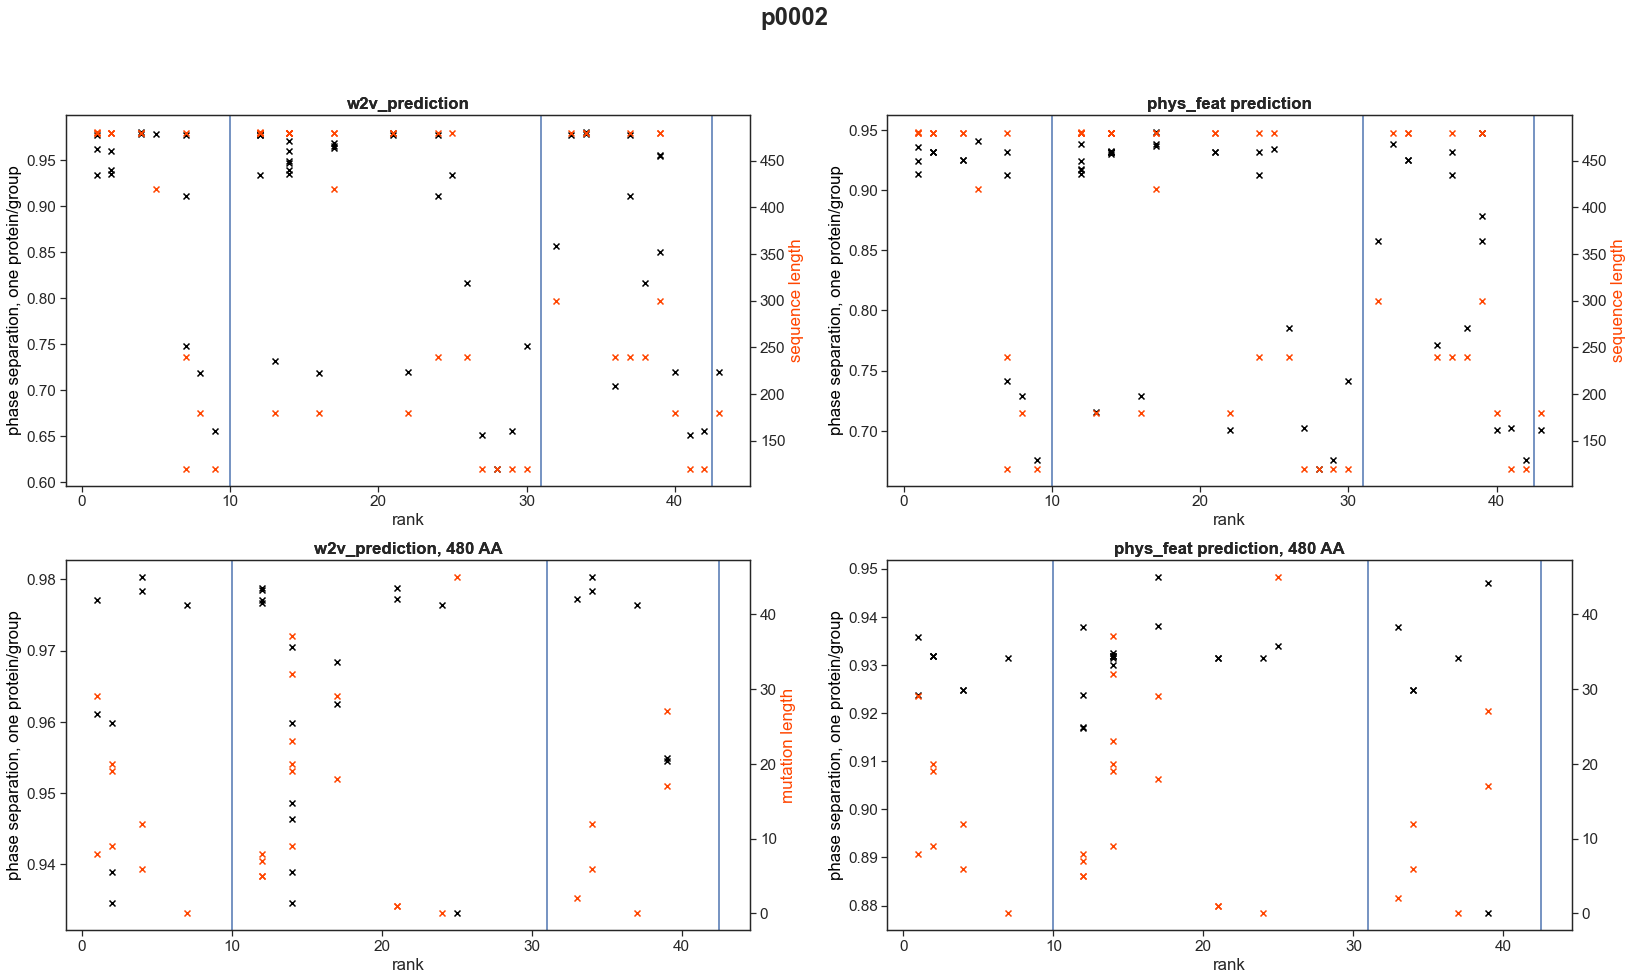

In [26]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(27,15))


ax5 = ax1.twinx()
ax6 = ax2.twinx()
ax7 = ax3.twinx()
ax8 = ax4.twinx()

ax1.scatter(df5['rank'], df5['w2v_multi'], c = 'black', marker = 'x')
ax1.set_title('w2v_prediction', fontweight="bold")

ax5.scatter(df5['rank'], df5['protein_len'], c = 'orangered', marker = 'x')
ax5.set_title('w2v_prediction', fontweight="bold")

ax2.scatter(df5['rank'], df5['phys_multi'], c = 'black', marker = 'x')
ax2.set_title('phys_feat prediction', fontweight="bold")

ax6.scatter(df5['rank'], df5['protein_len'], c = 'orangered', marker = 'x')
ax6.set_title('phys_feat prediction', fontweight="bold")


ax1.axvline(x=10)
ax1.axvline(x=31)
ax1.axvline(x=42.5)

ax2.axvline(x=10)
ax2.axvline(x=31)
ax2.axvline(x=42.5)

ax3.axvline(x=10)
ax3.axvline(x=31)
ax3.axvline(x=42.5)

ax4.axvline(x=10)
ax4.axvline(x=31)
ax4.axvline(x=42.5)

ax3.scatter(df_m['rank'], df_m['w2v_multi'], c = 'black', marker = 'x')
ax3.set_title('w2v_prediction, 480 AA', fontweight="bold")

ax7.scatter(df_m['rank'], df_m['mutation_len'], c = 'orangered', marker = 'x')
ax7.set_title('w2v_prediction, 480 AA', fontweight="bold")

ax4.scatter(df_m['rank'], df_m['phys_multi'], c = 'black', marker = 'x')
ax4.set_title('phys_feat prediction, 480 AA', fontweight="bold")

ax8.scatter(df_m['rank'], df_m['mutation_len'], c = 'orangered', marker = 'x')
ax8.set_title('phys_feat prediction, 480 AA', fontweight="bold")



ax1.set_xlabel('rank')
ax2.set_xlabel('rank')
ax3.set_xlabel('rank')
ax4.set_xlabel('rank')
ax1.set_ylabel('phase separation, one protein/group', color='black')
ax2.set_ylabel('phase separation, one protein/group', color='black')
ax3.set_ylabel('phase separation, one protein/group', color='black')
ax4.set_ylabel('phase separation, one protein/group', color='black')
ax5.set_ylabel('sequence length', color='orangered')
ax6.set_ylabel('sequence length', color='orangered')
ax7.set_ylabel('mutation length', color='orangered')
ax7.set_ylabel('mutation length', color='orangered')
    
plt.suptitle("p0002", fontsize=24, fontweight = 'bold')
plt.show()
#plt.savefig('1prot-group.png')

In [17]:
from scipy.stats import spearmanr

In [27]:
df4['phys_corrected'] = 1 - df4['phys_multi']
df4['w2v_corrected'] = 1 - df4['w2v_multi']
df3['phys_corrected'] = 1 - df3['phys_multi']
df3['w2v_corrected'] = 1 - df3['w2v_multi']
df2['phys_corrected'] = 1 - df2['phys_multi']
df2['w2v_corrected'] = 1 - df2['w2v_multi']
df1['phys_corrected'] = 1 - df1['phys_multi']
df1['w2v_corrected'] = 1 - df1['w2v_multi']
df0['phys_corrected'] = 1 - df0['phys_multi']
df0['w2v_corrected'] = 1 - df0['w2v_multi']

In [29]:
correl4 = df4.corr(method = 'spearman')
correl3 = df3.corr(method = 'spearman')
correl2 = df2.corr(method = 'spearman')
correl1 = df1.corr(method = 'spearman')
correl0 = df0.corr(method = 'spearman')

In [34]:
phys = {'4': correl4.loc['rank'][-2], '3': correl3.loc['rank'][-2], '2': correl2.loc['rank'][-2], '1': correl1.loc['rank'][-2], '0': correl0.loc['rank'][-2],  'family members': len(df5) }
w2v = {'4': correl4.loc['rank'][-1], '3': correl3.loc['rank'][-1], '2': correl2.loc['rank'][-1], '1': correl1.loc['rank'][-1], '0': correl0.loc['rank'][-1],  'family members': len(df5) }

In [35]:
phys_correl = pd.DataFrame(data = phys, index = ['p0002'])
w2v_correl = pd.DataFrame(data = w2v, index = ['p0002'])

In [36]:
phys_correl.to_csv('phys_p0002.csv')
w2v_correl.to_csv('w2v_p0002.csv')

In [37]:
phys_correl

,4,3,2,1,0,family members
p0002,0.538138,0.323626,0.54546,NaN,NaN,56
